In [1]:
# import libraries 
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os

import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

from skimage import io, color
from skimage.feature import local_binary_pattern
from skimage.feature import canny
from skimage.filters import sobel, sobel_h, sobel_v
from scipy.stats import entropy


In [2]:
# calculate average size to help inform a size to resize all images to
imagex = 0
imagey = 0
for i in range(1, 5489):    
    image = Image.open(f'Data/train/img_00{i:04d}.jpg')
    imagex += image.size[0]
    imagey += image.size[1]
    
print(imagex/5488) # 50.567237609329446
print(imagey/5488) # 50.05648688046647

# scale to 50 x 50
rescale_size = (50, 50)

50.567237609329446
50.05648688046647


In [3]:
# import paths and labels
train_metadata = pd.read_csv("Data/train/train_metadata.csv", index_col="id")
train_paths = train_metadata["image_path"]
train_class = train_metadata["ClassId"]

# import test set
test_metadata = pd.read_csv("Data/test/test_metadata.csv")
test_paths = test_metadata["image_path"]
test_index = test_metadata["id"]

# Neural Network

In [ ]:
# import image files as pixel RGB values

train_data = []
train_labels = []

for i in range(len(train_paths)):
    try:
        # open image
        image = Image.open(f"Data/train/{train_paths.iloc[i]}")
        # resize image to (50, 50)
        image = image.resize(rescale_size)
        image = np.array(image)
        train_data.append(image)
        train_labels.append(train_class.iloc[i])
    except:
        print(f"error loading image {train_paths.iloc[i]}")

data = np.array(train_data)
labels = np.array(train_labels)

In [ ]:
# sanity check data

print(f"data has shape: {data.shape}")
print(f"labels have shape: {labels.shape}")

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=69)

print(f"X_train has shape: {X_train.shape}")
print(f"X_test has shape: {X_test.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"y_test has shape: {y_test.shape}")

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

data has shape: (5488, 50, 50, 3)
labels have shape: (5488,)
X_train has shape: (4390, 50, 50, 3)
X_test has shape: (1098, 50, 50, 3)
y_train has shape: (4390,)
y_test has shape: (1098,)
(4390, 43)


In [53]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#M odel display
model.summary() 

C:\Users\rayzh\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833,899 (33.70 MB)

 Trainable params: 8,833,899 (33.70 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Training the Model
with tf.device('/GPU:0'):
    epochs = 35
    history1 = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.0855 - loss: 14.9181 - val_accuracy: 0.4299 - val_loss: 2.1528
Epoch 2/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.5303 - loss: 1.8151 - val_accuracy: 0.8215 - val_loss: 0.8276
Epoch 3/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.8068 - loss: 0.6909 - val_accuracy: 0.9308 - val_loss: 0.3511
Epoch 4/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.9052 - loss: 0.3525 - val_accuracy: 0.9353 - val_loss: 0.2423
Epoch 5/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9348 - loss: 0.2465 - val_accuracy: 0.9472 - val_loss: 0.2105
Epoch 6/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.9421 - loss: 0.2191 - val_accuracy: 0.9599 - val_loss: 0.1975
Epoch 7/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.9605 - loss: 0.1597 - val_accuracy: 0.9545 - val_loss: 0.1896
Epoch 8/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.9643 - loss: 0.1286 - val_accuracy: 0

In [ ]:
test_data = []
test_id = []

for i in range(len(test_paths)):
    try:
        # open image
        image = Image.open(f"Data/test/{test_paths.iloc[i]}")
        # resize image to (50, 50)
        image = image.resize(rescale_size)
        image = np.array(image)
        test_data.append(image)
        test_id.append(test_index.iloc[i])
    except:
        print(f"error loading image {test_paths.iloc[i]}")

test_data = np.array(test_data)

print(test_data.shape)
print(test_id)


(2353, 50, 50, 3)
[np.int64(661), np.int64(4477), np.int64(1046), np.int64(631), np.int64(6533), np.int64(2899), np.int64(1941), np.int64(5749), np.int64(588), np.int64(1333), np.int64(5826), np.int64(7493), np.int64(4306), np.int64(3429), np.int64(1191), np.int64(4076), np.int64(1601), np.int64(2183), np.int64(4214), np.int64(5366), np.int64(5434), np.int64(6709), np.int64(2421), np.int64(4247), np.int64(5722), np.int64(1115), np.int64(1730), np.int64(6673), np.int64(156), np.int64(2011), np.int64(4416), np.int64(4661), np.int64(6511), np.int64(4411), np.int64(821), np.int64(6246), np.int64(3934), np.int64(5711), np.int64(3233), np.int64(3738), np.int64(4561), np.int64(3780), np.int64(6288), np.int64(3115), np.int64(7155), np.int64(7603), np.int64(1932), np.int64(6387), np.int64(6001), np.int64(4376), np.int64(2393), np.int64(5025), np.int64(660), np.int64(7634), np.int64(1978), np.int64(2398), np.int64(2826), np.int64(2679), np.int64(1466), np.int64(1953), np.int64(3887), np.int64(56

In [ ]:
# predict classes of test data
with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(test_data), axis=-1)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [82]:
result = pd.DataFrame({'id': test_index, 'ClassId': pred})
result.to_csv("results.csv", index=False)

# Feature Extraction

### LBP

In [16]:
# hyperparameters
r = 1
points = r * 8
method = 'uniform'

# extract image paths
all_images = train_metadata["image_path"]
lbp_data = []
lbp_images = []

# extract lbp values
for path in all_images:
    image = Image.open(f"Data/train/{path}")
    image = image.resize(rescale_size)
    gray_image = color.rgb2gray(image)

    lbp = local_binary_pattern(gray_image, points, r, method)

    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    lbp_data.append(hist)
    lbp_images.append(path)


lbp = pd.DataFrame(lbp_data)
lbp.insert(0, 'image_path', lbp_images)
lbp.index = train_metadata.index

lbp.to_csv('lbp.csv', index=False)

c:\Users\rayzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


### Canny Edge Detection

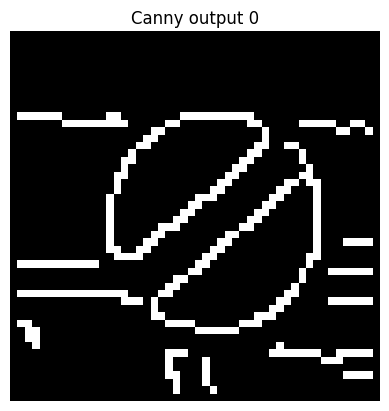

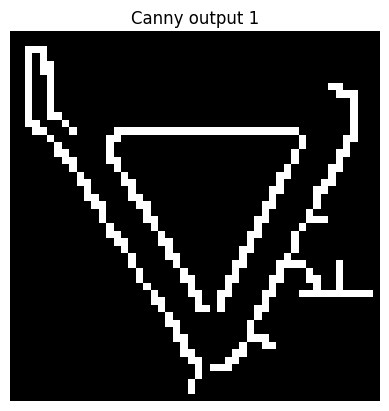

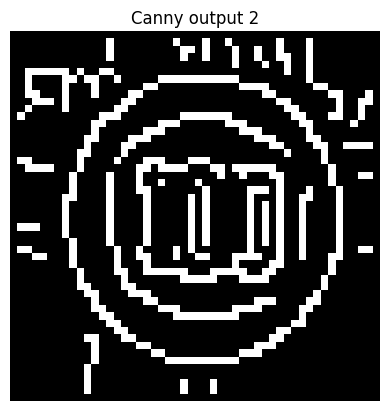

In [14]:
# Hyperparameter
SIGMA = 1

all_images = train_metadata["image_path"]
canny_data = []
canny_images = []

for path in all_images:
    image = Image.open(f"Data/train/{path}")
    image = image.resize(rescale_size)
    image_array = np.array(image)
    gray_image = color.rgb2gray(image_array)

    edges = canny(gray_image, sigma=SIGMA)

    canny_data.append(edges.astype(np.float32)) 
    canny_images.append(path)

canny_flat = [edge.flatten() for edge in canny_data]
canny_flat = pd.DataFrame(canny_flat)
canny_flat.insert(0, 'image_path', canny_images)
canny_flat.index = train_metadata.index

for i in range(3):
    plt.imshow(canny_data[i], cmap='gray')
    plt.title(f"Canny output {i}")
    plt.axis('off')
    plt.show()    

In [106]:
# tuning the value of sigma using entropy
entropies = []

for data in canny_data:
    values, counts = np.unique(data.astype(int), return_counts=True)
    probs = counts / counts.sum() 
    entropies.append(float(entropy(probs, base=2)))

print(np.mean(entropies)) 
# sigma = 1: 0.5726
# sigma = 2: 0.3871
# sigma = 3: 0.2597

# choose sigma = 1

0.5660983399760839


In [107]:
X = canny_flat.drop(columns=['image_path']).values  

pca = PCA(n_components=0.75)  # reduce dimensions but keep 75% of the variance
X_pca = pca.fit_transform(X)

print(f"Original shape: {X.shape}")
print(f"Reduced shape: {X_pca.shape}")

canny_df = pd.DataFrame(X_pca, index=canny_flat.index)

# Add the image_path column back
canny_df.insert(0, 'image_path', canny_flat['image_path'])

canny_df.to_csv('canny.csv', index=False)



Original shape: (2353, 2500)
Reduced shape: (2353, 458)


### Sobel Filtering

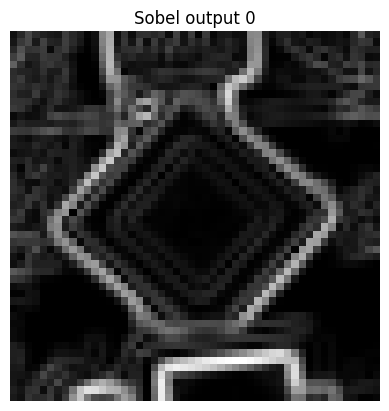

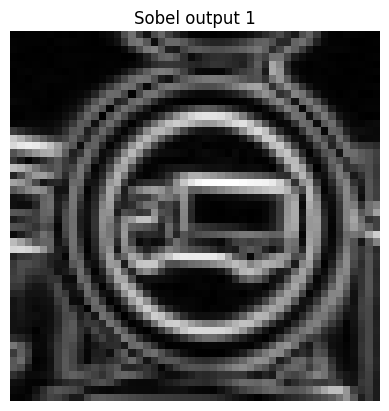

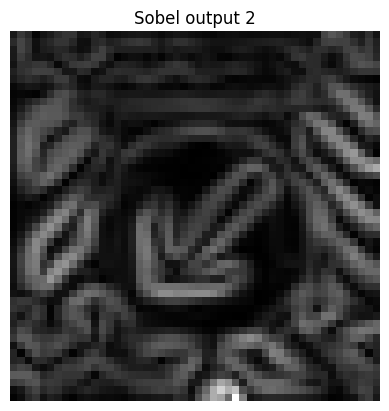

In [15]:
all_images = test_metadata["image_path"]
sobel_data = []
sobel_images = []

for path in all_images:
    image = Image.open(f"Data/test/{path}")
    image = image.resize(rescale_size)
    image_array = np.array(image)
    gray_image = color.rgb2gray(image_array)

    sobel_edge = sobel(gray_image)

    # sx = sobel_h(gray_image)
    # sy = sobel_v(gray_image)
    # sobel_edge = np.hypot(sx, sy)

    sobel_data.append(sobel_edge.flatten())
    sobel_images.append(path)

sobel_df = pd.DataFrame(sobel_data)
sobel_df.index = test_metadata.index

for i in range(3):
    sobel_image = sobel_df.iloc[i].values.reshape(rescale_size)
    plt.imshow(sobel_image, cmap='gray')
    plt.title(f"Sobel output {i}")
    plt.axis('off')
    plt.show()

In [137]:
X = sobel_df.values  

pca = PCA(n_components=0.75)  
X_pca = pca.fit_transform(X)

print(f"Original shape: {X.shape}")
print(f"Reduced shape: {X_pca.shape}")

sobel_df = pd.DataFrame(X_pca, index=sobel_df.index)
sobel_df.insert(0, 'image_path', sobel_images)

sobel_df.to_csv('sobel.csv', index=False)

Original shape: (2353, 2500)
Reduced shape: (2353, 101)


## Scaling Data

In [31]:
train_add_features = pd.read_csv("Data/train/Features/additional_features.csv").drop(columns=['image_path'])
train_edge_density = train_add_features[["edge_density"]]
train_mean_rgb = train_add_features.drop(columns=["edge_density"])
train_canny = pd.read_csv("Data/train/Features/canny.csv").drop(columns=['image_path'])
train_color_hist = pd.read_csv("Data/train/Features/color_histogram.csv").drop(columns=['image_path'])
train_hog_pca = pd.read_csv("Data/train/Features/hog_pca.csv").drop(columns=['image_path'])
train_lbp = pd.read_csv("Data/train/Features/lbp.csv").drop(columns=['image_path'])
train_sobel = pd.read_csv("Data/train/Features/sobel.csv").drop(columns=['image_path'])


scaler1 = StandardScaler()
train_edge_density_scaled = scaler1.fit_transform(train_edge_density)

scaler2 = StandardScaler()
train_mean_rgb_scaled = scaler2.fit_transform(train_mean_rgb)

scaler3 = StandardScaler()
train_canny_scaled = scaler3.fit_transform(train_canny)

scaler4 = StandardScaler()
train_color_hist_scaled = scaler4.fit_transform(train_color_hist)

scaler5 = StandardScaler()
train_hog_pca_scaled = scaler5.fit_transform(train_hog_pca)

scaler6 = StandardScaler()
train_lbp_scaled = scaler6.fit_transform(train_lbp)

scaler7 = StandardScaler()
train_sobel_scaled = scaler7.fit_transform(train_sobel)


In [34]:
train_edge_density



,edge_density
0,0.050293
1,0.034424
2,0.126709
3,0.026123
4,0.106934
...,...
5483,0.100586
5484,0.034180
5485,0.247559
5486,0.038818
